In [24]:
from __future__ import absolute_import, division, print_function, unicode_literals

#! pip install tensorflow
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# import norm
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2

# Helper libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import imageio as image

import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display


import os
from os import listdir
from os.path import isfile, join
import pickle
import random
#importing module
import sys
sys.path.insert(0, '../data')
from datahandler_multilabel import create_dataset

from PIL import ImageFile, Image

import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
with open('../data/train_test_split.pkl', 'rb') as infile:
    train_x, train_y, val_x, val_y, test_x, test_y = pickle.load(infile)

len(train_x), len(train_y), len(val_x), len(val_y), len(test_x), len(test_y[0])

(18000, 18000, 3000, 3000, 3999, 15)

In [3]:
#import keras
file = 'training_flat_multilabelVGG_weights_1.h5'
model = tf.keras.models.load_model('./results/'+file, compile=False,)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
hidden_layer (Dense)         (None, 2048)              1050624   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 700)               1434300   
_________________________________________________________________
dropout (Dropout)            (None, 700)               0         
_________________________________________________________________
output (Dense)               (None, 15)                10515     
Total params: 17,210,127
Trainable params: 2,495,439
Non-trainable params: 14,714,688
____________________________________

In [4]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

def mean_per_class_accuracy(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    per_class_acc = []
    per_class_acc.append(tf.cast(tf.math.count_nonzero(y_pred[i] * y[i], axis=0), tf.float32))
    mean_acc = tf.reduce_mean(per_class_acc)
    return mean_acc

def precision(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    pres = tp / (tp + fp + 1e-16)
    precision = tf.reduce_mean(pres)
    return precision

def recall(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    rec = tp / (tp + fn + 1e-16)
    recall = tf.reduce_mean(rec)
    return recall

In [395]:
adam = tf.keras.optimizers.Adam(name='Adam')
model.compile(optimizer= adam,
              loss=tf.keras.losses.binary_crossentropy,
              metrics=["binary_accuracy",
                       precision,
                       recall,
                       macro_f1
                      ])

In [396]:
train_generator = create_dataset(train_x, train_y)
val_generator = create_dataset(val_x, val_y)
test_generator = create_dataset(test_x, test_y)

In [130]:
model.evaluate(test_generator, verbose=2)

72/72 - 398s - loss: 0.4021 - binary_accuracy: 0.8343 - precision: 0.4852 - recall: 0.2943 - macro_f1: 0.3324


[0.4020522894958655, 0.83425874, 0.48516905, 0.29430547, 0.33241227]

In [20]:
pred = model.predict_generator(test_generator, verbose=1)

72/72 [==============================] - 2121s 29s/step


In [8]:
predicted_class_indices = np.where(pred > 0.5, 1, 0)
print(predicted_class_indices)

[[1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [45]:
import pickle 
with open('saved_predictions.pkl', 'rb') as infile:
    predicted_class_indices = pickle.load(infile)
    
predicted_class_indices

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [398]:
def mean_per_class_accuracy(y, y_hat, num_classes):
    accuracy = [0]*num_classes
    for i in range(num_classes):
        accuracy[i] = 0
        for j in range(len(y)):
            if y[j][i] == y_hat[j][i]:
                accuracy[i] += 1
        accuracy[i] /= len(y)
    return accuracy

def mean_per_item_accuracy(y, y_hat, num_classes):
    accuracy = [0]*len(y)
    for i in range(len(y)):
        accuracy[i] = 0
        for j in range(num_classes):
            if y[i][j] == y_hat[i][j]:
                accuracy[i] += 1
        accuracy[i] /= num_classes
    return sum(accuracy)/len(y)


In [399]:
per_class_accuracy = mean_per_class_accuracy(
    test_y, predicted_class_indices, 15
)
per_class_accuracy, sum(per_class_accuracy)/15

([0.5103775943985996,
  0.5598899724931233,
  0.6149037259314829,
  0.5643910977744436,
  0.5803950987746936,
  0.6196549137284321,
  0.48562140535133785,
  0.6346586646661665,
  0.8902225556389097,
  0.7749437359339835,
  0.8792198049512379,
  0.8997249312328082,
  0.9032258064516129,
  0.935233808452113,
  0.9022255563890973],
 0.7169792448112028)

In [400]:
per_item_accuracy = mean_per_item_accuracy(
    test_y, predicted_class_indices, 15
)
per_item_accuracy

0.7169792448111868

### Visualizing Confusion Matrices

In [401]:
confusion = np.zeros((15,15))

for j in range(len(test_y)):
    equal = []
    for i in range(15):
        if test_y[j][i] == 1:
            if test_y[j][i] == predicted_class_indices[j][i]:
                confusion[i][i] += 1
                equal += [i] 
            else: 
                indices = list(set(np.where(predicted_class_indices[j] == 1)[0])^set(equal)) 
                count_predictions = len(indices)
                if count_predictions != 0:
                    confusion[i][indices] += round(1/count_predictions, 2)
        
    
confusion = np.round(confusion).astype(int)

print(confusion)

[[1212   46   85  103  387   27  215  107    5    1   16    1    1    2
     5]
 [  68  368   97  131  277   44  252   87    1   14   12    8    1    1
     9]
 [  93   57  268   56  206   33  139   78   14   26   13    8    2    2
     9]
 [ 103   69   13  393  255   45  155  100   14   36   14   10    1    3
    10]
 [ 177   62   75   97  357   41  188   49   11   24    3    6    1    1
     9]
 [  70   52   47   61  199  197  241  110   18   27   12    7    2    2
    11]
 [ 147  102   16   39  316   32  895  141   24   39   22   10    2    3
    14]
 [ 115   40   73   80   95   26  111  251   11   21    9    7    1    1
     7]
 [  13    5   22   21   55   13   53   23    9    8    5    4    1    1
     3]
 [   7   23   40   44  143   23   75   45   10   59    6    6    2    2
     9]
 [  60   19   28   31   50   13   49   23    4    9   15    3    1    1
     5]
 [  14   17   28   32   59   14   29   19    7   10    5    8    0    2
     2]
 [   8   10   25   28   81   12   35   3

In [31]:
confusion_ = np.zeros((15,15))

for j in range(len(test_y)):
    equal = []
    for i in range(15):
        if test_y[j][i] == 1:
            if test_y[j][i] == predicted_class_indices[j][i]:
                confusion_[i][i] += 1
                equal += [i] 
            else: 
                indices = list(set(np.where(predicted_class_indices[j] == 1)[0])^set(equal)) 
                count_predictions = len(indices)
                if count_predictions != 0:
                    confusion_[i][indices] += round(1/count_predictions, 2)
        else:
            if test_y[j][i] == predicted_class_indices[j][i]:
                confusion_[i][i] += 1
                equal += [i] 
            else: 
                indices = list(set(np.where(predicted_class_indices[j] == 0)[0])^set(equal)) 
                count_predictions = len(indices)
                if count_predictions != 0:
                    confusion_[i][indices] += round(1/count_predictions, 2)
        #elif test_y[j][i] == 0:
            #count_predictions = sum(predicted_class_indices[i])
            #if count_predictions != 0:
            #    indices = list(set(np.where(predicted_class_indices[j] == 1)[0])^set(equal)) 
            #    confusion[i][indices] = round(1/count_predictions, 2)
    


print(np.round(confusion_).astype(int))

[[2041   93  142  156  459   84  253  169   79   65   95   77   80   81
    81]
 [ 154 2239  139  166  301   81  273  116   48   53   64   61   55   55
    63]
 [ 151  250 2459   57  203   72  110  123   80   85   80   77   70   70
    74]
 [ 153  256  160 2257  218   88  112  139   85   95   86   84   77   78
    82]
 [ 190  168  195  197 2321   99  165   73   86   95   74   82   80   79
    82]
 [  93  160  172  164  292 2478  135   93   63   55   58   58   55   54
    61]
 [ 154  221  156  141  325  180 1942  147  108  106  109  100   99   99
   100]
 [ 121  106  157  149  139  116  138 2538   75   77   72   77   75   73
    77]
 [  21   15   49   44   59   38   52   39 3560   14   23   21   20   21
    21]
 [  22   44   85   76  133   62   71   91  104 3099   43   41   40   41
    41]
 [  37   32   52   46   39   32   40   29   56   45 3516   18   17   15
    19]
 [  12   24   38   37   44   28   23   30   42   35   35 3598   17   18
    13]
 [   8   17   32   28   45   26   21   3

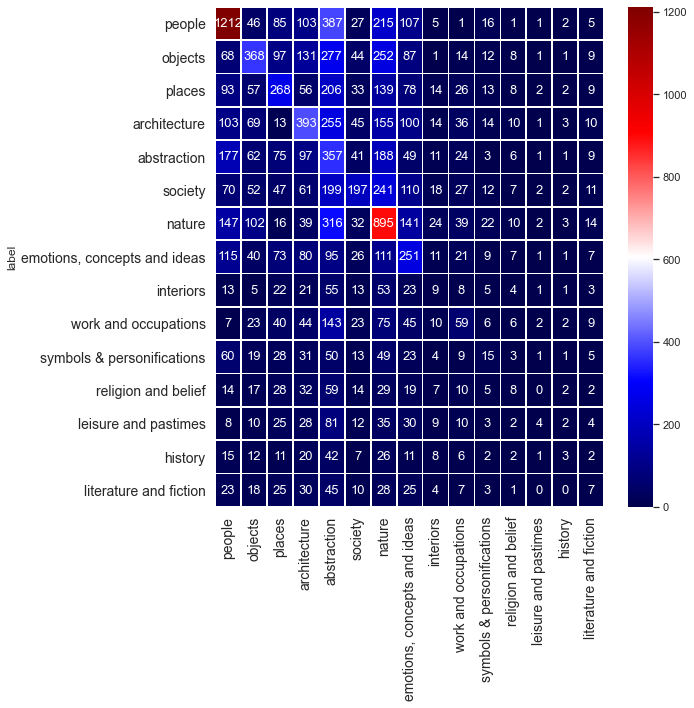

In [403]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


conf = pd.DataFrame(confusion, columns=['people','objects','places','architecture','abstraction','society',\
          'nature','emotions, concepts and ideas','interiors','work and occupations', \
          'symbols & personifications','religion and belief','leisure and pastimes',\
          'history','literature and fiction'])
conf = pd.concat([conf, pd.Series(['people','objects','places','architecture','abstraction','society',\
          'nature','emotions, concepts and ideas','interiors','work and occupations', \
          'symbols & personifications','religion and belief','leisure and pastimes',\
          'history','literature and fiction'], name='label')], axis=1)
conf = conf.set_index(conf.label)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf.drop('label', axis=1), annot=True, fmt="d", linewidths=.7, ax=ax, cmap='seismic', annot_kws={"size": 13})
ax.set_xticklabels(labels=conf.columns, fontsize = 14)
ax.set_yticklabels(labels=conf.columns, fontsize = 14)
plt.tight_layout()

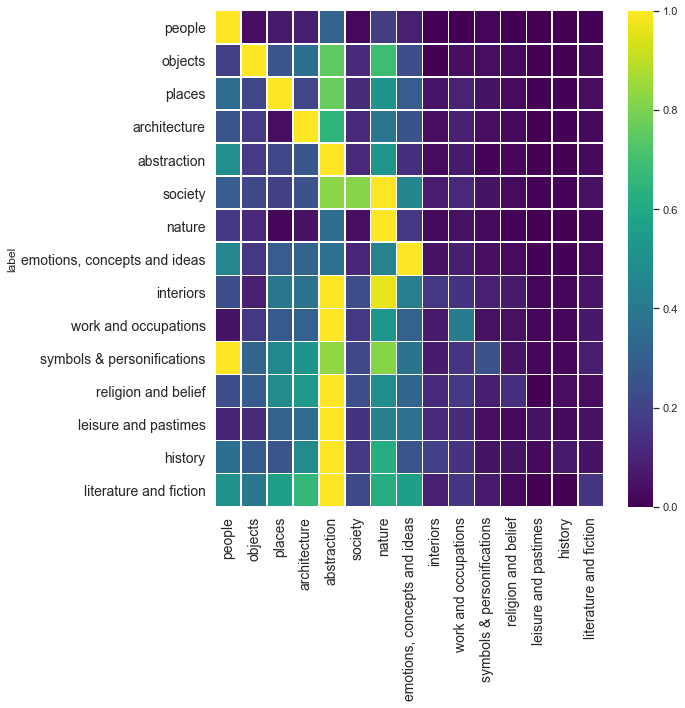

In [404]:
confusion = confusion.astype(float)
for i in range(len(confusion)):
    confusion[i,:] = np.divide(confusion[i,:], max(confusion[i,:]))

conf = pd.DataFrame(confusion, columns=['people','objects','places','architecture','abstraction','society',\
          'nature','emotions, concepts and ideas','interiors','work and occupations', \
          'symbols & personifications','religion and belief','leisure and pastimes',\
          'history','literature and fiction'])
conf = pd.concat([conf, pd.Series(['people','objects','places','architecture','abstraction','society',\
          'nature','emotions, concepts and ideas','interiors','work and occupations', \
          'symbols & personifications','religion and belief','leisure and pastimes',\
          'history','literature and fiction'], name='label')], axis=1)
conf = conf.set_index(conf.label)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf.drop('label', axis=1), annot=False, linewidths=.5, ax=ax,cmap='viridis')
ax.set_xticklabels(labels=conf.columns, fontsize = 14)
ax.set_yticklabels(labels=conf.columns, fontsize = 14)
plt.tight_layout()

In [16]:
conf_matrix = multilabel_confusion_matrix(test_y, predicted_class_indices)
print(conf_matrix)

[[[ 545 1201]
  [ 692 1561]]

 [[1665  832]
  [ 999  503]]

 [[2566  354]
  [ 920  159]]

 [[1764  902]
  [ 858  475]]

 [[2444  402]
  [ 997  156]]

 [[2191  602]
  [ 939  267]]

 [[1148  833]
  [1200  818]]

 [[2637  353]
  [ 901  108]]

 [[3665   56]
  [ 274    4]]

 [[3153  194]
  [ 617   35]]

 [[3421  197]
  [ 362   19]]

 [[3520  162]
  [ 305   12]]

 [[3591   59]
  [ 346    3]]

 [[3761   24]
  [ 214    0]]

 [[3617   99]
  [ 278    5]]]


In [53]:
from sklearn import metrics
precision = metrics.precision_score(test_y, predicted_class_indices, average=None)
recall = metrics.recall_score(test_y, predicted_class_indices, average=None)
f1 = metrics.f1_score(test_y, predicted_class_indices, average=None)
print(precision, '\n', recall, '\n', f1, '\n', sum(precision)/15, '\n', sum(recall)/15, '\n', sum(f1)/15)

[0.56640803 0.38038943 0.27805865 0.33419466 0.31024668 0.30245536
 0.51995798 0.22222222 0.06060606 0.16283525 0.12589928 0.07096774
 0.12790698 0.07070707 0.04878049] 
 [0.55082113 0.36418109 0.25486562 0.29107277 0.28360798 0.22470978
 0.49058474 0.18235877 0.04316547 0.1303681  0.09186352 0.03470032
 0.03151862 0.03271028 0.02826855] 
 [0.55850585 0.37210884 0.26595745 0.31114675 0.29632986 0.25784967
 0.50484447 0.20032662 0.05042017 0.14480409 0.10622155 0.04661017
 0.05057471 0.04472843 0.03579418] 
 0.2387757251191992 
 0.20231978202283007 
 0.216414854052866


In [36]:
from sklearn import metrics

In [37]:
metrics.average_precision_score(test_y, predicted_class_indices, average='weighted')

0.3403664551117709

In [38]:
import sklearn
print(sklearn.metrics.classification_report(test_y, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.57      0.54      0.55      2253
           1       0.37      0.25      0.29      1502
           2       0.27      0.25      0.26      1079
           3       0.33      0.29      0.31      1333
           4       0.29      0.31      0.30      1153
           5       0.28      0.16      0.21      1206
           6       0.49      0.44      0.47      2018
           7       0.26      0.25      0.26      1009
           8       0.05      0.03      0.04       278
           9       0.16      0.09      0.12       652
          10       0.11      0.04      0.06       381
          11       0.08      0.03      0.04       317
          12       0.09      0.01      0.02       349
          13       0.06      0.01      0.02       214
          14       0.06      0.02      0.03       283

   micro avg       0.37      0.29      0.32     14027
   macro avg       0.23      0.18      0.20     14027
weighted avg       0.34   

C:\Users\Ludovica\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
labels_dict = {0:'people',1:'objects',2:'places',3:'architecture',4:'abstraction',5:'society',\
          6:'nature',7:'emotions, concepts and ideas',8:'interiors',9:'work and occupations', \
          10:'symbols & personifications',11:'religion and belief',12:'leisure and pastimes',\
          13:'history',14:'literature and fiction',15:'group/movement'}
predictions = [[]]*(len(predicted_class_indices)-1)
actual = [[]]*len(test_y)
for k in range(len(predicted_class_indices)-1):
    predictions[k] = []
    actual[k] = []
    for i in range(len(predicted_class_indices[k])):
        if predicted_class_indices[k][i] == 1:
            predictions[k].append(labels_dict[i])
        if test_y[k][i] == 1:
            actual[k].append(labels_dict[i])
            
print(len(predictions), len(actual))

3998 3999


In [40]:
results=pd.DataFrame({"Filename":test_x[:-1],
                      "Actual":actual[:-1],
                      "Predictions":predictions,
                      })
results.to_csv("./results/results"+file+"1.csv",index=False)

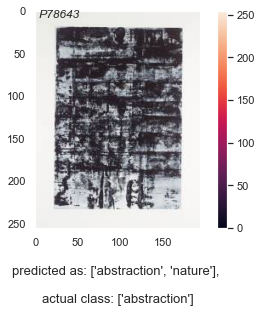

In [113]:
number = random.randrange(0, 4000, 1)
results = pd.read_csv("./results/results"+file+"1.csv")
img  = Image.open(str(results.Filename[number]))
plt.figure()
plt.text(3, 8, results.Filename[number].split('\\')[-1].split('_')[0], style='italic',)
plt.xlabel(f'\npredicted as: {results.Predictions[number]}, \n\nactual class: {results.Actual[number]}', fontsize=13)#, verticalalignment='bottom', horizontalalignment='left')
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

### Evaluation of CNN-RNN

In [3]:
import torch
from CNN_RNN.model_attention import DecoderRNN
model = DecoderRNN(512, 1024, 19, 1).to('cpu')
checkpoint = torch.load('./results/decoder-5-600.ckpt', map_location=torch.device('cpu'))
print(checkpoint.keys())
model.load_state_dict(checkpoint)
model.eval()

odict_keys(['att_bias', 'embed.weight', 'lstm_cell.weight_ih', 'lstm_cell.weight_hh', 'lstm_cell.bias_ih', 'lstm_cell.bias_hh', 'linear.weight', 'linear.bias', 'att_vw.weight', 'att_hw.weight', 'att_w.weight'])


DecoderRNN(
  (embed): Embedding(19, 512)
  (lstm_cell): LSTMCell(1024, 1024)
  (linear): Linear(in_features=1024, out_features=19, bias=True)
  (att_vw): Linear(in_features=512, out_features=512, bias=False)
  (att_hw): Linear(in_features=1024, out_features=512, bias=False)
  (att_w): Linear(in_features=512, out_features=1, bias=False)
)

In [4]:
import pickle
import numpy as np

with open('./results/predictions_CNN_RNN_vgg.pkl', 'rb') as infile:
    predictions = pickle.load(infile)
reals = []
predicted = []
test_x = []
for key in predictions.keys():
    test_x.append(key)
    reals.append(predictions[key][1])
    preds = []
    for i in range(len(predictions[key][0])):
        preds += [np.argmax(predictions[key][0][i])]
    predicted.append(preds)
    
len(predicted), len(reals)
predicted[:3]
test_x[:3]

['T09446_8.jpg', 'T09626_8.jpg', 'T12579_8.jpg']

In [5]:
predicted_class_indices = []
test_y = []

for i in range(len(predicted)):
    predicted_class_indices.append([0]*15)
    test_y.append([0]*15)
    for j in range(len(predicted[i])):
        if predicted[i][j] > 2:
            predicted_class_indices[i][predicted[i][j]-4] = 1
        if reals[i][j] > 2:
            test_y[i][reals[i][j]-4] = 1

predicted_class_indices[:10], test_y[:10]

([[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [6]:
from sklearn import metrics
precision = metrics.precision_score(test_y, predicted_class_indices, average=None)
recall = metrics.recall_score(test_y, predicted_class_indices, average=None)
f1 = metrics.f1_score(test_y, predicted_class_indices, average=None)
print(precision, '\n', recall, '\n', f1, '\n\n', sum(precision)/15, '\n', sum(recall)/15, '\n', sum(f1)/17)

[0.72985782 0.26553672 0.50816697 0.42720307 0.40818713 0.74079834
 0.08333333 0.58388942 0.36078431 0.66556291 0.33196721 0.25925926
 0.31182796 0.42823529 0.        ] 
 [0.82294264 0.13239437 0.32444959 0.39122807 0.30480349 0.5308321
 0.00380228 0.68897638 0.58974359 0.34795153 0.23546512 0.05236908
 0.3452381  0.67657993 0.        ] 
 [0.77361018 0.17669173 0.3960396  0.40842491 0.349      0.61848085
 0.00727273 0.63209494 0.44768856 0.45699128 0.2755102  0.08713693
 0.32768362 0.52449568 0.        ] 

 0.40697398372688576 
 0.363118417028557 
 0.3224188951185998


In [ ]:
per_class_accuracy = mean_per_class_accuracy(
    test_y, predicted_class_indices, 15
)
per_class_accuracy, sum(per_class_accuracy)/15

In [29]:
per_item_accuracy = mean_per_item_accuracy(
    test_y, predicted_class_indices, 15
)
per_item_accuracy

0.8282779778578224

In [30]:
print(metrics.classification_report(test_y, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.73      0.82      0.77      2807
           1       0.27      0.13      0.18       355
           2       0.51      0.32      0.40       863
           3       0.43      0.39      0.41       570
           4       0.41      0.30      0.35      1145
           5       0.74      0.53      0.62      2692
           6       0.08      0.00      0.01       263
           7       0.58      0.69      0.63      1778
           8       0.36      0.59      0.45       936
           9       0.67      0.35      0.46      1733
          10       0.33      0.24      0.28       344
          11       0.26      0.05      0.09       401
          12       0.31      0.35      0.33       252
          13       0.43      0.68      0.52       538
          14       0.00      0.00      0.00       124

   micro avg       0.57      0.51      0.54     14801
   macro avg       0.41      0.36      0.37     14801
weighted avg       0.57   

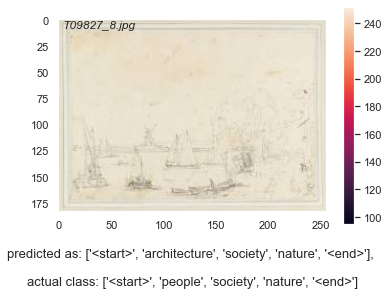

In [381]:
vocab = ['<pad>', '<start>', '<end>', '<unk>', 'people', 'religion and belief', 'emotions, concepts and ideas', 'work and occupations', 'society', 'nature', 'literature and fiction', 'objects', 'places', 'architecture', 'symbols & personifications', 'leisure and pastimes', 'interiors', 'abstraction', 'history']

number = random.randrange(0, 3000, 1)
img = Image.open('../../data_tate/'+ list(predictions.keys())[number])
plt.figure()
plt.imshow(img)
plt.text(3, 8, list(predictions.keys())[number], style='italic',)
plt.xlabel(f'\npredicted as: {[vocab[int(i)] for i in reals[number]]}, \n\nactual class: {[vocab[int(i)] for i in predicted[number]]}', fontsize=13)#, verticalalignment='bottom', horizontalalignment='left')
plt.colorbar()
plt.grid(False)
plt.show()

In [382]:
def evaluate(y, y_pred, thresh=0.5):
    tp = np.count_nonzero(y_pred * y)
    fp = np.count_nonzero(y_pred * (1 - y))
    fn = np.count_nonzero((1 - y_pred) * y)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = np.mean(f1)
    pres = tp / (tp + fp + 1e-16)
    precision = np.mean(pres)
    rec = tp / (tp + fn + 1e-16)
    recall = np.mean(rec)
    return macro_f1, precision, recall

In [383]:
evaluate(np.array(test_y), np.array(predicted_class_indices))

(0.322789102078264, 0.3664191269697519, 0.28844371569116706)

In [387]:
confusion = np.zeros((15,15))

for j in range(len(test_y)):
    equal = []
    for i in range(15):
        if test_y[j][i] == 1:
            if test_y[j][i] == predicted_class_indices[j][i]:
                confusion[i][i] += 1
                equal += [i] 
            else: 
                indices = list(set(np.where(predicted_class_indices[j] == 1)[0])^set(equal)) 
                count_predictions = len(indices)
                if count_predictions != 0:
                    confusion[i][indices] += round(1/count_predictions, 2)
        
    
confusion = np.round(confusion).astype(int)

print(confusion)

[[2310    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [ 235   47    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [ 228    8  280    0    0    0    0    0    0    0    0    0    0    0
     0]
 [ 268    3   16  223    0    0    0    0    0    0    0    0    0    0
     0]
 [ 400    6   84   23  349    0    0    0    0    0    0    0    0    0
     0]
 [ 360   10   59   33    9 1429    0    0    0    0    0    0    0    0
     0]
 [ 161    5   14    4   13   28    1    0    0    0    0    0    0    0
     0]
 [ 133    1   52    9   34   83    0 1225    0    0    0    0    0    0
     0]
 [  79    1   20    3   24  129    0   28  552    0    0    0    0    0
     0]
 [ 217    3   25   24   39  531    0   87    4  603    0    0    0    0
     0]
 [  53    4   12    2   13   27    0   35    6   10   81    0    0    0
     0]
 [ 179    1   10   10   13   25    0   99    7    6    2   21    0    0
     0]
 [  57    1    3   12    5    7    0   3

[Text(0, 0.5, 'people'),
 Text(0, 1.5, 'religion and belief'),
 Text(0, 2.5, 'emotions, concepts and ideas'),
 Text(0, 3.5, 'work and occupations'),
 Text(0, 4.5, 'society'),
 Text(0, 5.5, 'nature'),
 Text(0, 6.5, 'literature and fiction'),
 Text(0, 7.5, 'objects'),
 Text(0, 8.5, 'places'),
 Text(0, 9.5, 'architecture'),
 Text(0, 10.5, 'symbols & personifications'),
 Text(0, 11.5, 'leisure and pastimes'),
 Text(0, 12.5, 'interiors'),
 Text(0, 13.5, 'abstraction'),
 Text(0, 14.5, 'history')]

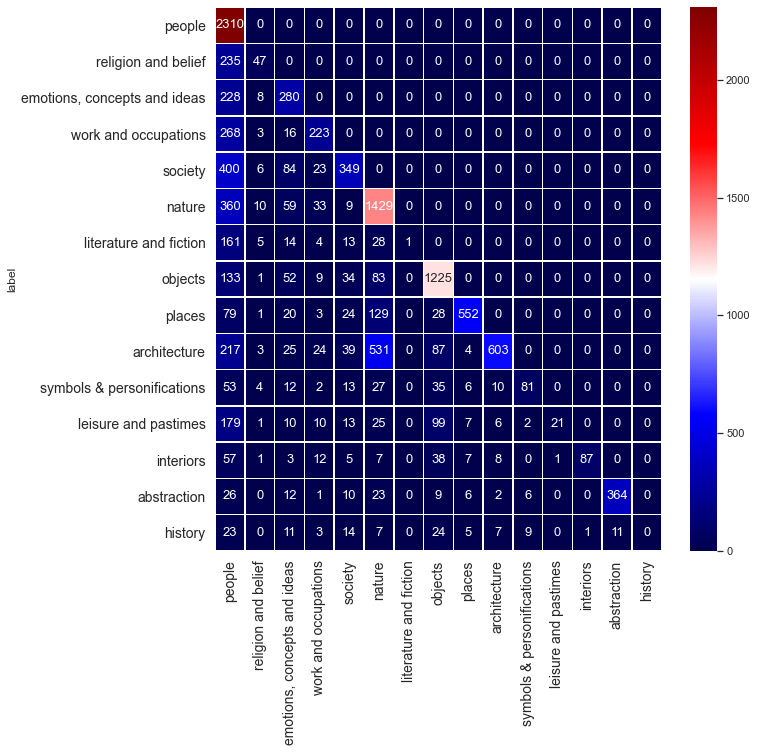

In [389]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


conf = pd.DataFrame(confusion, columns=['people', 'religion and belief', 'emotions, concepts and ideas', 'work and occupations', 'society', 'nature', 'literature and fiction', 'objects', 'places', 'architecture', 'symbols & personifications', 'leisure and pastimes', 'interiors', 'abstraction', 'history'])
conf = pd.concat([conf, pd.Series(['people', 'religion and belief', 'emotions, concepts and ideas', 'work and occupations', 'society', 'nature', 'literature and fiction', 'objects', 'places', 'architecture', 'symbols & personifications', 'leisure and pastimes', 'interiors', 'abstraction', 'history'], name='label')], axis=1)
conf = conf.set_index(conf.label)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf.drop('label', axis=1), annot=True, fmt="d", linewidths=.5, ax=ax,cmap='seismic', annot_kws={"size": 13})
ax.set_xticklabels(labels=conf.columns, fontsize = 14)
ax.set_yticklabels(labels=conf.columns, fontsize = 14)

[Text(0, 0.5, 'people'),
 Text(0, 1.5, 'religion and belief'),
 Text(0, 2.5, 'emotions, concepts and ideas'),
 Text(0, 3.5, 'work and occupations'),
 Text(0, 4.5, 'society'),
 Text(0, 5.5, 'nature'),
 Text(0, 6.5, 'literature and fiction'),
 Text(0, 7.5, 'objects'),
 Text(0, 8.5, 'places'),
 Text(0, 9.5, 'architecture'),
 Text(0, 10.5, 'symbols & personifications'),
 Text(0, 11.5, 'leisure and pastimes'),
 Text(0, 12.5, 'interiors'),
 Text(0, 13.5, 'abstraction'),
 Text(0, 14.5, 'history')]

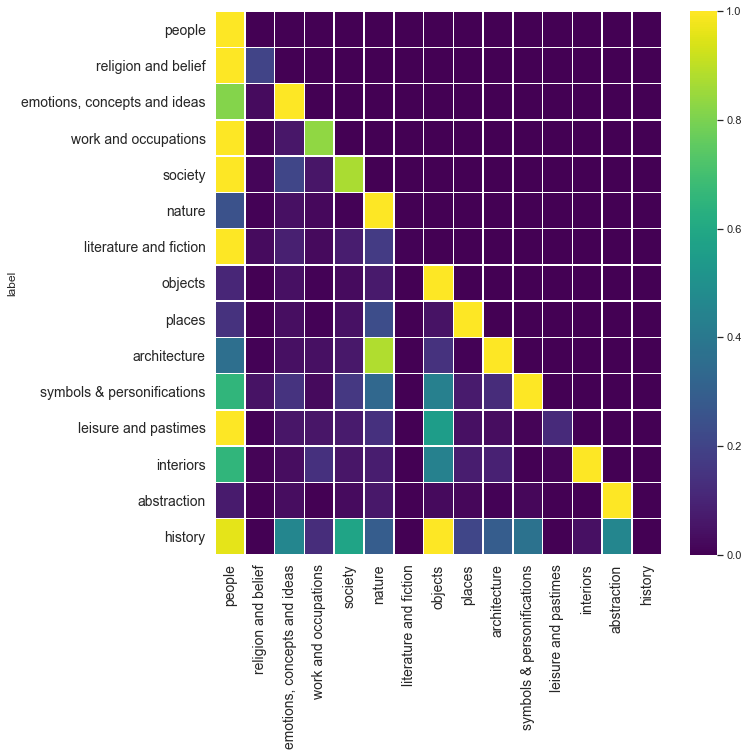

In [390]:
confusion = confusion.astype(float)
for i in range(len(confusion)):
    confusion[i,:] = np.divide(confusion[i,:], max(confusion[i,:]))

conf = pd.DataFrame(confusion, columns=['people', 'religion and belief', 'emotions, concepts and ideas', 'work and occupations', 'society', 'nature', 'literature and fiction', 'objects', 'places', 'architecture', 'symbols & personifications', 'leisure and pastimes', 'interiors', 'abstraction', 'history'])
conf = pd.concat([conf, pd.Series(['people', 'religion and belief', 'emotions, concepts and ideas', 'work and occupations', 'society', 'nature', 'literature and fiction', 'objects', 'places', 'architecture', 'symbols & personifications', 'leisure and pastimes', 'interiors', 'abstraction', 'history'], name='label')], axis=1)
conf = conf.set_index(conf.label)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf.drop('label', axis=1), annot=False, linewidths=.5, ax=ax,cmap='viridis')
ax.set_xticklabels(labels=conf.columns, fontsize = 14)
ax.set_yticklabels(labels=conf.columns, fontsize = 14)

### Visualizing intermediate activations

In [406]:
layer_outputs = [layer.output for layer in model.get_layer("vgg16").layers] # Extracts the outputs of the top 12 layers
activation_model = tf.keras.models.Model(inputs=model.get_layer("vgg16").get_layer("input_1").input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

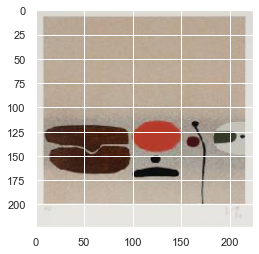

artwork: ..\..\data_tate\P05536_8.jpg
predicted as: ['abstraction'] 
actual class: ['abstraction']


In [520]:
number = random.randrange(0, 4000, 1)
results = pd.read_csv("./results/results_Naive_VGG_weight.csv")
#img_path = test_x[number].replace("\\", '/')
img_path  = str(results.Filename[number])
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print('artwork:', results.Filename[number])
print('predicted as:', results.Predictions[number],
     '\nactual class:', results.Actual[number])

In [521]:
activations = activation_model.predict(img_tensor) 

In [522]:
first_layer_activation = activations[3]
print(first_layer_activation.shape)

(1, 112, 112, 64)


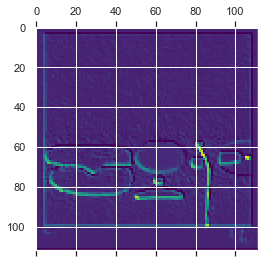

In [523]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')

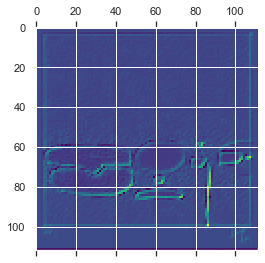

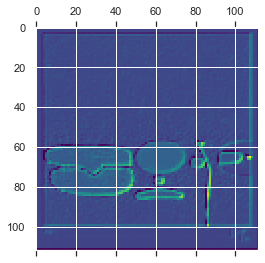

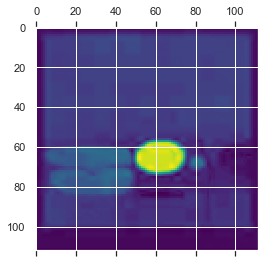

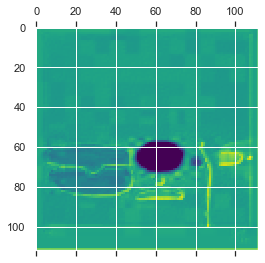

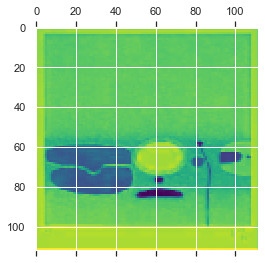

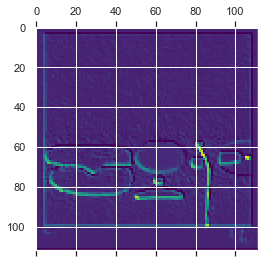

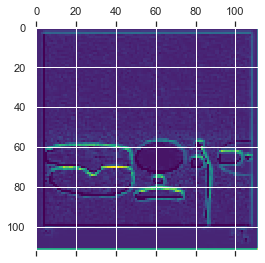

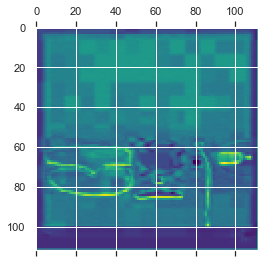

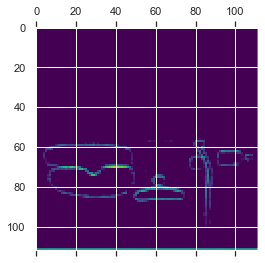

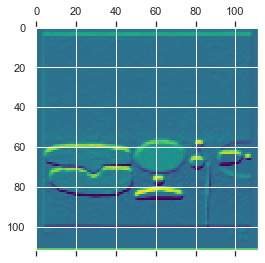

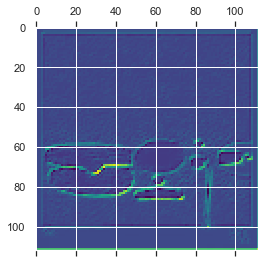

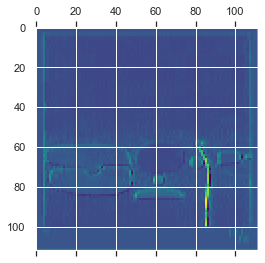

In [524]:
for i in range(12):
    plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

In [525]:
import matplotlib.pyplot as plt
from vis.visualization import visualize_saliency
from vis.utils import utils
from tensorflow.keras import activations
import matplotlib.image as mpimg
import scipy.ndimage as ndimage

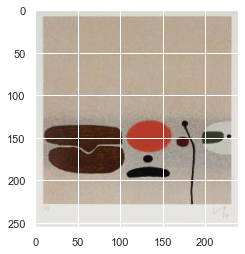

In [526]:
#img_path = test_x[number].replace("\\", '/')
img_path  = str(results.Filename[number])
img=mpimg.imread(img_path)
plt.imshow(img)

### Visualizing Saliency Map and GradCAM

Saliency generate the saliency map that appears input regions that a change in the input value contribute the output value.

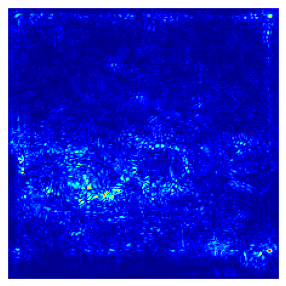

In [527]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Create Saliency object
saliency = Saliency(model, model_modifier)

loss= lambda output: K.mean(output)

img_path  = str(results.Filename[number])
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
# Generate saliency map
saliency_map = saliency(loss, img_tensor)
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
for i in range(len(saliency_map)):
    ax.imshow(saliency_map[i], cmap='jet')

Saliency is one of useful way of visualizing attention that appears input regions that a change in the input value contribute the output value. GradCAM is another way of visualizing attention over input. Instead of using gradients with respect to model outputs, it uses penultimate (pre Dense layer) Conv layer output.

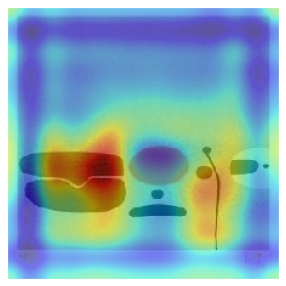

In [528]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

layer_outputs = [layer.output for layer in model.get_layer("vgg16").layers]  # Extracts the outputs of the top 12 layers
activation_model = tf.keras.models.Model(inputs=model.get_layer("vgg16").get_layer("input_1").input, outputs=layer_outputs) 

# Create Gradcam object
gradcam = Gradcam(activation_model, model_modifier)

cam = gradcam(loss, img_tensor)
cam = normalize(cam)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5),
                     subplot_kw={'xticks': [], 'yticks': []})
for i in range(len(cam)):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax.imshow(img)
    ax.imshow(heatmap, cmap='jet', alpha=0.5)

DO NOT RUN THE FOLLOWING CELL
It takes ages to run

213
312
32
40
276
226
472
367
457
283
273
247
222
484
491
323


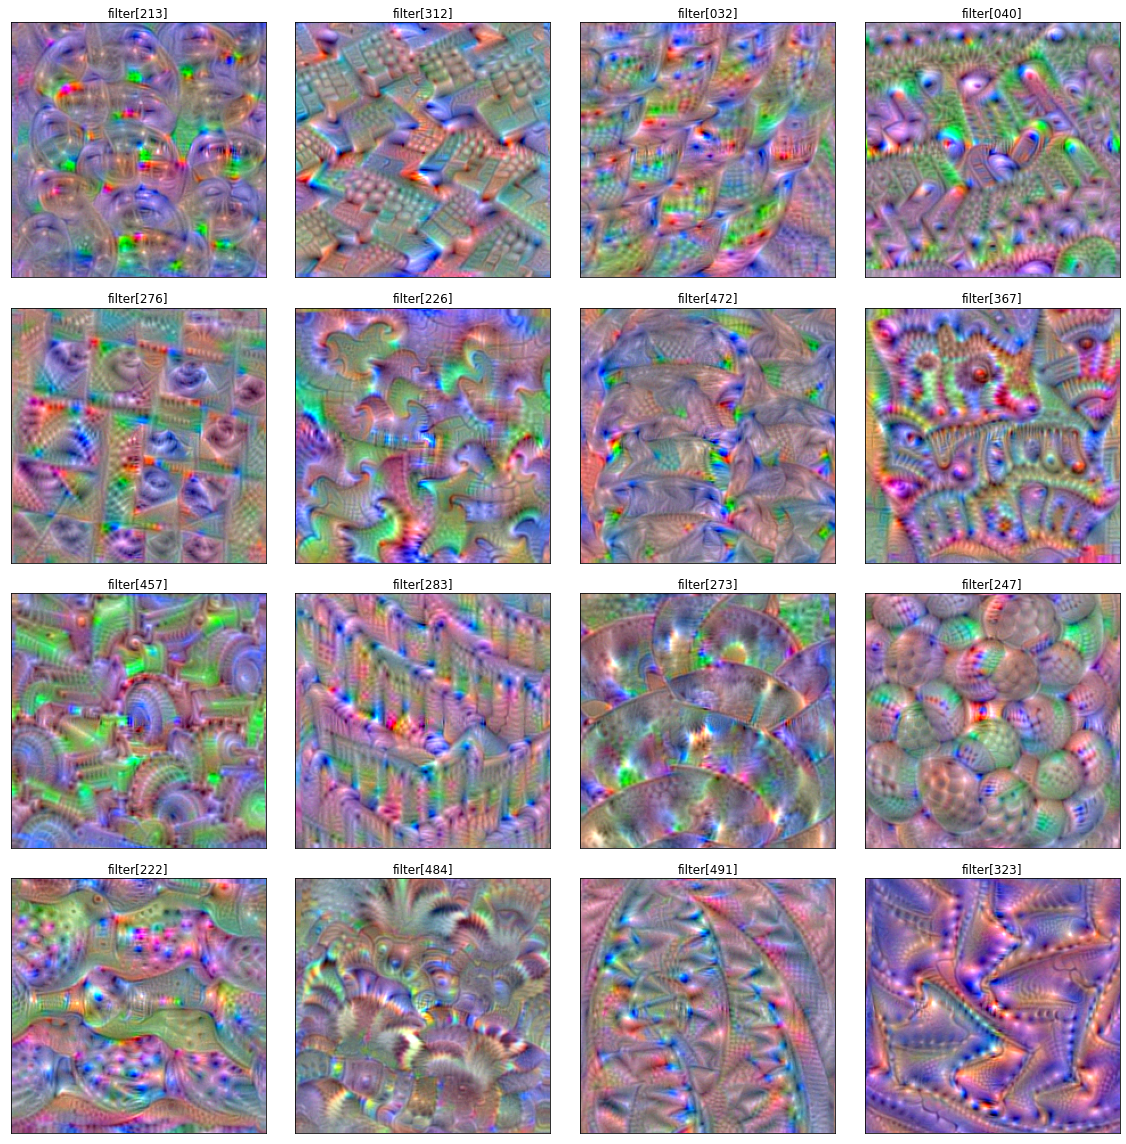

In [116]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.losses import SmoothedLoss

# The target layer that is the last layer of VGG16.
layer_name = 'block5_conv3'

# Define modifier to replace the model output to target layer's output.
# You need to return new model when you create new model instance in model_modifier.
def model_modifier(m):
    new_model = tf.keras.Model(inputs=m.inputs, outputs=[m.get_layer(name=layer_name).output])
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

# Create Activation Maximization object
activation_maximization = ActivationMaximization(activation_model, model_modifier)

num_of_filters = 16
filter_numbers = np.random.choice(activation_model.get_layer(name=layer_name).output.shape[-1], num_of_filters)
cols = 4
rows = num_of_filters // cols
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 4, rows * 4), subplot_kw={'xticks': [], 'yticks': []})

for i, filter_number in enumerate(filter_numbers):
    print(filter_number)
    # Define loss function that is sum of a filter output.
    loss = SmoothedLoss(filter_number)

    # Generate max activation
    activation = activation_maximization(loss)
    img = activation[0].astype(np.uint8)
    ax[i // cols][i % cols].imshow(img)
    ax[i // cols][i % cols].set_title('filter[{:03d}]'.format(filter_number))

plt.tight_layout()
plt.show()

#### Results of evalute.py

In [2]:
with open('evals.pkl', 'rb') as infile:
    evals = pickle.load(infile)

evals.keys()

dict_keys(['training_flat_multilabel_ResNetfine_tuned.h5', 'training_flat_multilabel_VGGfine_tuned.h5', 'training_flat_multilabel_InceptionV3fine_tuned.h5', 'training_flat_multilabelVGG.h5', 'training_flat_multilabelInceptionV3.h5', 'training_flat_multilabelResNet.h5'])

### Plotting result records

In [3]:
list_paths = ['training_flat_multilabel_ResNet_fine_tuned.csv', \
                  'training_flat_multilabel_VGG_fine_tuned.csv', \
                  'training_flat_multilabel_InceptionV3_fine_tuned.csv', \
                  'training_flat_multilabel_VGG.csv', \
                  'training_flat_multilabel_InceptionV3_weights.csv', \
                  'training_flat_multilabel_InceptionV3.csv', \
                  'training_flat_multilabel_ResNet.csv', \
                  'training_flat_multilabel_ResNet_weights.csv', \
                  'training_flat_multilabel_VGG_weights_1.csv', \
                 ]
record_model = {}
for record in list_paths:
    print(record)
    with open('./results/'+ record, 'rb') as infile:
        record_model[record] = pd.read_csv(infile)

training_flat_multilabel_ResNet_fine_tuned.csv
training_flat_multilabel_VGG_fine_tuned.csv
training_flat_multilabel_InceptionV3_fine_tuned.csv
training_flat_multilabel_VGG.csv
training_flat_multilabel_InceptionV3_weights.csv
training_flat_multilabel_InceptionV3.csv
training_flat_multilabel_ResNet.csv
training_flat_multilabel_ResNet_weights.csv
training_flat_multilabel_VGG_weights_1.csv


In [4]:
record_model['training_flat_multilabel_VGG.csv']

epoch  binary_accuracy      loss  macro_f1  precision    recall  \
0       0         0.819685  0.409017  0.266184   0.345012  0.245549   
1       1         0.834374  0.379012  0.322395   0.421252  0.291883   
2       2         0.839504  0.367835  0.345339   0.449310  0.312305   
3       3         0.842115  0.360694  0.356460   0.464959  0.320597   
4       4         0.845167  0.354021  0.372261   0.487706  0.334065   
5       5         0.847755  0.348905  0.389863   0.512782  0.348863   
6       6         0.850882  0.342420  0.403640   0.534755  0.359800   
7       7         0.853014  0.337053  0.414824   0.547573  0.369683   
8       8         0.855148  0.331987  0.428668   0.565117  0.382098   
9       9         0.858022  0.326095  0.444747   0.587224  0.396101   
10     10         0.859696  0.321658  0.452081   0.591264  0.403166   
11     11         0.862429  0.316393  0.469071   0.614848  0.418163   
12     12         0.864852  0.310490  0.477659   0.621721  0.426783   
13     13         0.867130  0.304820  0.489945   0.632724  0.438346   
14     14         0.870237  0.298180  0.504037   0.645878  0.451185   
15     15         0.872000  0.294756  0.513520   0.654746  0.461545   
16     16         0.875000  0.288063  0.527747   0.670882  0.475110   
17     17         0.877100  0.283330  0.539712   0.685065  0.485477   
18     18         0.880111  0.277339  0.552651   0.695638  0.498757   
19     19         0.882433  0.271082  0.569007   0.707456  0.515097   
20     20         0.884985  0.265361  0.577000   0.713449  0.522940   
21     21         0.887637  0.260333  0.588715   0.728724  0.534030   
22     22         0.890700  0.254421  0.601256   0.736648  0.547597   
23     23         0.892489  0.248766  0.613687   0.747978  0.560667   
24     24         0.895011  0.242870  0.616251   0.743567  0.565398   
25     25         0.898059  0.236868  0.637304   0.765046  0.585104   
26     26         0.899807  0.232879  0.639874   0.764021  0.589612   
27     27         0.903203  0.225838  0.658123   0.778624  0.607798   
28     28         0.905374  0.221417  0.668406   0.788170  0.619194   
29     29         0.906752  0.216551  0.674171   0.789898  0.625926   
30     30         0.909919  0.211487  0.687087   0.801563  0.637973   
31     31         0.911374  0.207663  0.694851   0.804611  0.648364   
32     32         0.913655  0.202955  0.704842   0.812032  0.659542   
33     33         0.915707  0.198054  0.711749   0.814823  0.667242   
34     34         0.917993  0.191554  0.717969   0.819812  0.673027   
35     35         0.920059  0.188509  0.732970   0.832150  0.687994   
36     36         0.921812  0.183885  0.737667   0.830887  0.696069   
37     37         0.923478  0.181156  0.744200   0.832958  0.703956   
38     38         0.924944  0.175755  0.748917   0.837707  0.709923   
39     39         0.926855  0.173551  0.752742   0.836395  0.715325   
40     40         0.928766  0.168547  0.762042   0.846837  0.723486   
41     41         0.930622  0.164862  0.770602   0.854509  0.733660   
42     42         0.932430  0.161126  0.775898   0.855481  0.738971   
43     43         0.932989  0.158787  0.778019   0.854807  0.742166   
44     44         0.935003  0.155398  0.787974   0.862097  0.755373   
45     45         0.936711  0.151571  0.791523   0.864179  0.758466   
46     46         0.937218  0.149926  0.793821   0.863346  0.762813   
47     47         0.938681  0.146942  0.798343   0.865529  0.768038   
48     48         0.939315  0.144268  0.803103   0.869763  0.773359   
49     49         0.941544  0.140569  0.810779   0.874937  0.781229   
50     50         0.942059  0.138999  0.814467   0.876754  0.786419   
51     51         0.944096  0.135080  0.816211   0.877740  0.787516   
52     52         0.944566  0.133622  0.818856   0.877148  0.792250   
53     53         0.945300  0.130077  0.822963   0.880407  0.797009   
54     54         0.946163  0.129174  0.829214   0.885021  0.803841   
55     55         0.948182  

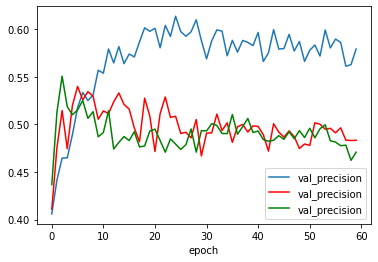

In [5]:
import matplotlib.pyplot as plt

# gca stands for 'get current axis'
ax = plt.gca()

record_model['training_flat_multilabel_VGG.csv'].plot(kind='line',x='epoch',y='val_precision',ax=ax)
record_model['training_flat_multilabel_InceptionV3.csv'].plot(kind='line',x='epoch',y='val_precision', color='red', ax=ax)
record_model['training_flat_multilabel_ResNet.csv'].plot(kind='line',x='epoch',y='val_precision', color='green', ax=ax)

plt.show()

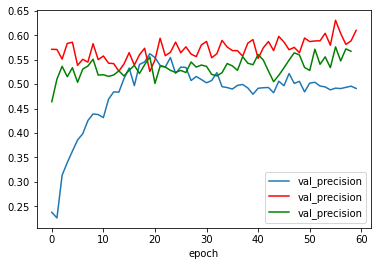

In [7]:
# gca stands for 'get current axis'
ax = plt.gca()

record_model['training_flat_multilabel_VGG_fine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision',ax=ax)
record_model['training_flat_multilabel_InceptionV3_fine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision', color='red', ax=ax)
record_model['training_flat_multilabel_ResNet_fine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision', color='green', ax=ax)

plt.show()

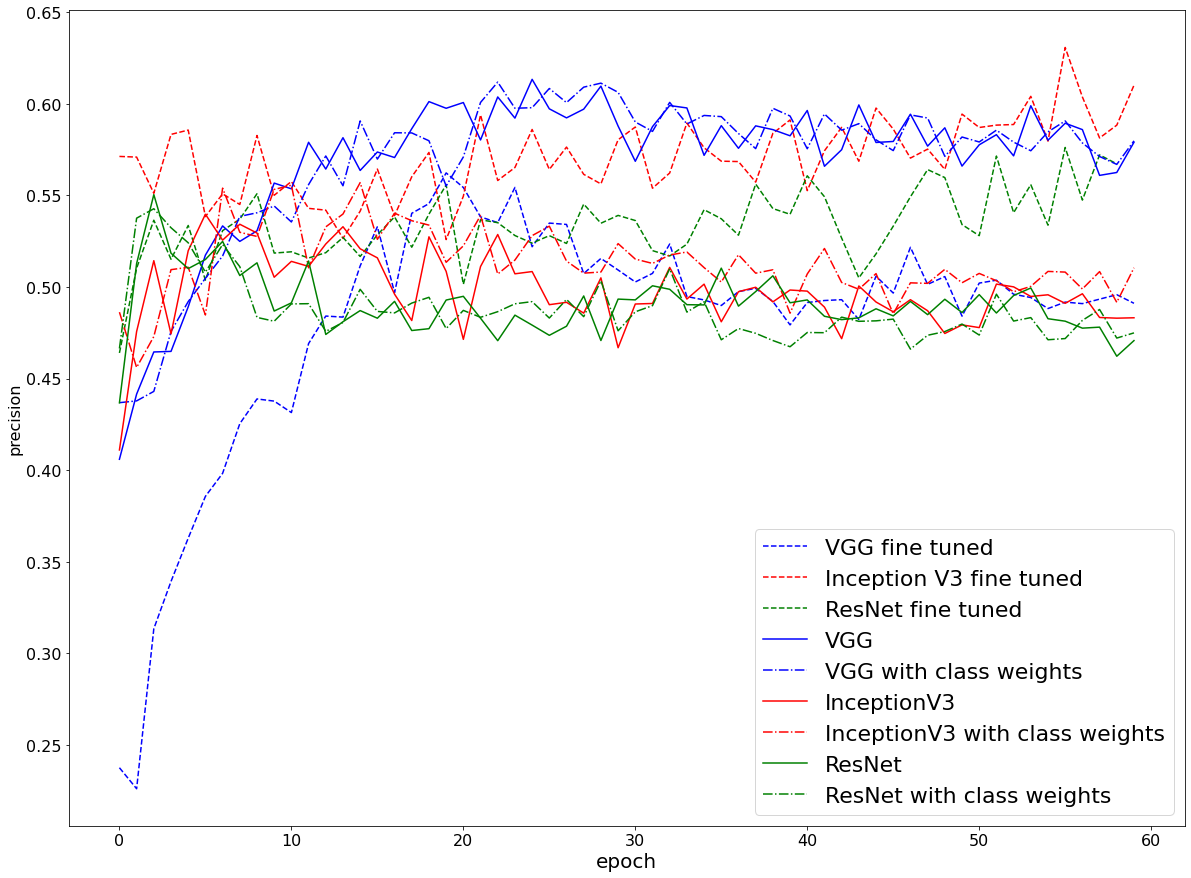

In [38]:
# gca stands for 'get current axis'
ax = plt.gca()
plt.rcParams["figure.figsize"] = (20, 15)
plt.rcParams.update({'font.size': 22})
line1 = record_model['training_flat_multilabel_VGG_fine_tuned.csv'].plot(kind='line', fontsize=16,x='epoch',y='val_precision', color='blue', style='--', ax=ax, label='VGG fine tuned')
line2 = record_model['training_flat_multilabel_InceptionV3_fine_tuned.csv'].plot(kind='line', fontsize=16,x='epoch',y='val_precision', color='red', style='--', ax=ax, label='Inception V3 fine tuned')
line3 = record_model['training_flat_multilabel_ResNet_fine_tuned.csv'].plot(kind='line',x='epoch',fontsize=16,y='val_precision', color='green', style='--', ax=ax, label='ResNet fine tuned')
line4 = record_model['training_flat_multilabel_VGG.csv'].plot(kind='line',x='epoch',y='val_precision', fontsize=16,color='blue', ax=ax, label='VGG')
line4_ = record_model['training_flat_multilabel_VGG_weights_1.csv'].plot(kind='line',x='epoch',y='val_precision', fontsize=16,color='blue', ax=ax, style='-.',label='VGG with class weights')
line5 = record_model['training_flat_multilabel_InceptionV3.csv'].plot(kind='line',x='epoch',y='val_precision', color='red', fontsize=16,ax=ax, label='InceptionV3')
line5 = record_model['training_flat_multilabel_InceptionV3_weights.csv'].plot(kind='line',x='epoch',y='val_precision', color='red', fontsize=16,ax=ax, style='-.', label='InceptionV3 with class weights')
line6 = record_model['training_flat_multilabel_ResNet.csv'].plot(kind='line',x='epoch',y='val_precision', color='green', ax=ax,fontsize=16, label='ResNet')
line6 = record_model['training_flat_multilabel_ResNet_weights.csv'].plot(kind='line',x='epoch',y='val_precision', color='green', style='-.',fontsize=16, ax=ax, label='ResNet with class weights')
plt.ylabel('precision',fontsize=16,)
plt.savefig('./results/precision_plot.png')
plt.show()

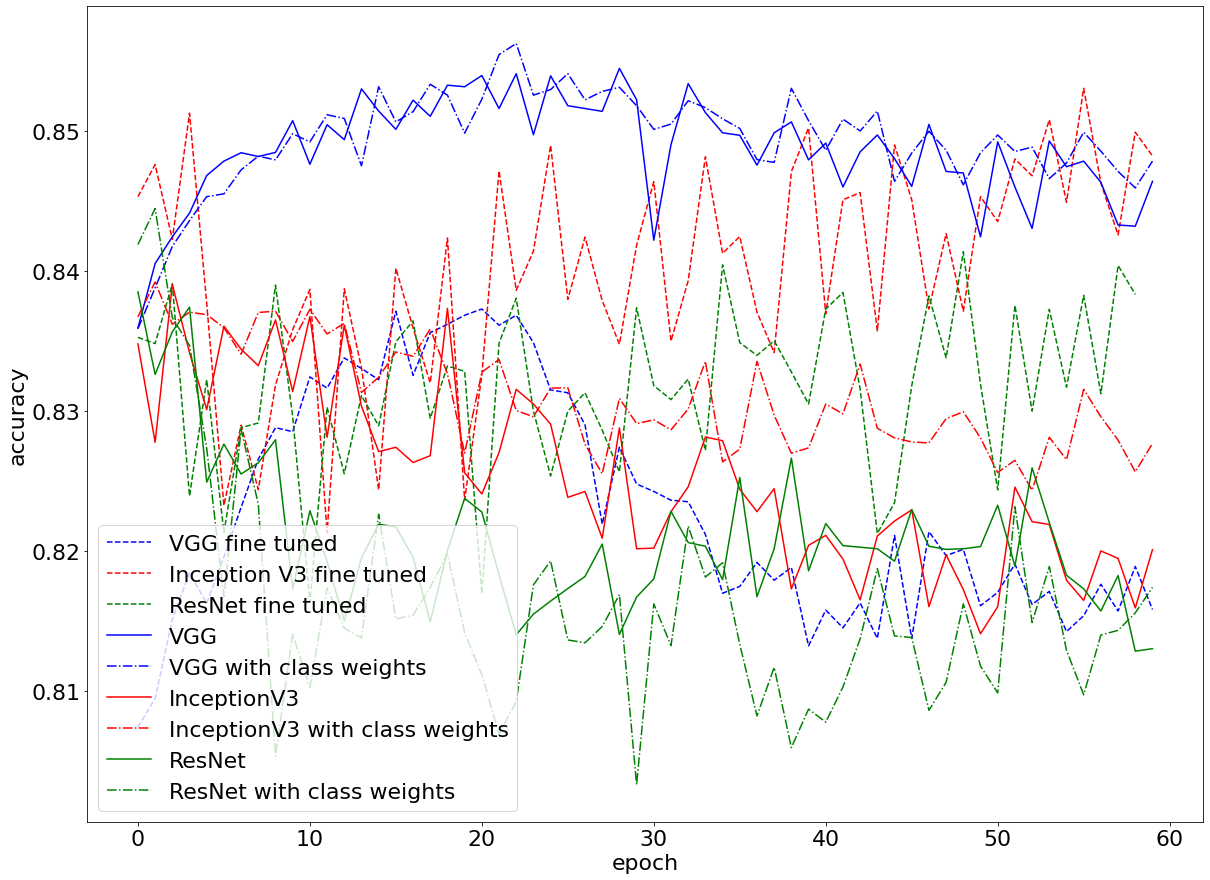

In [39]:
# gca stands for 'get current axis'
ax = plt.gca()
line1 = record_model['training_flat_multilabel_VGG_fine_tuned.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='blue', style='--', ax=ax, label='VGG fine tuned')
line2 = record_model['training_flat_multilabel_InceptionV3_fine_tuned.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='red', style='--', ax=ax, label='Inception V3 fine tuned')
line3 = record_model['training_flat_multilabel_ResNet_fine_tuned.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='green', style='--', ax=ax, label='ResNet fine tuned')
line4 = record_model['training_flat_multilabel_VGG.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='blue', ax=ax, label='VGG')
line4_ = record_model['training_flat_multilabel_VGG_weights_1.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='blue', ax=ax, style='-.',label='VGG with class weights')
line5 = record_model['training_flat_multilabel_InceptionV3.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='red', ax=ax, label='InceptionV3')
line5 = record_model['training_flat_multilabel_InceptionV3_weights.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='red', ax=ax, style='-.', label='InceptionV3 with class weights')
line6 = record_model['training_flat_multilabel_ResNet.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='green', ax=ax, label='ResNet')
line6 = record_model['training_flat_multilabel_ResNet_weights.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='green', style='-.', ax=ax, label='ResNet with class weights')
plt.ylabel('accuracy')
plt.savefig('./results/accuracy_plot.png')
plt.show()

### Visualizing the Models 

In [7]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

#%tensorboard --logdir logs

In [8]:
import tensorflow as tf
import datetime

In [ ]:
log_dir = os.path.join('.','results')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 100000)

model.fit(train_generator,
          epochs=1, 
          callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs

### Visualizing precision per year and per movement

In [81]:
import json
with open('../data/results/TateMovementsDict.json', 'rb') as infile:
    movements = json.load(infile)

In [82]:
list(movements.keys())[:3]

['P07010', 'P07011', 'P07013']

In [83]:
test_x[:3]

['T09446_8.jpg', 'T09626_8.jpg', 'T12579_8.jpg']

In [84]:
test_y[:3]

[[1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]

In [85]:
predicted_class_indices[:3]

[[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]

In [86]:
x = [x.split('\\')[-1].split('_')[0] for x in test_x]
x[:3]

['T09446', 'T09626', 'T12579']

In [87]:
mvm = pd.DataFrame(data=movements.values(), index=movements.keys(), columns=['movement'])
mvm

movement
P07010       Vorticism
P07011       Vorticism
P07013       Vorticism
P07014  Conceptual Art
P07015  Conceptual Art
...                ...
T03566         Fauvism
T03573   Impressionism
T03574   Impressionism
T03576    Early Stuart
T03588     Spazialismo

[5971 rows x 1 columns]

In [88]:
precision = [0]*len(test_y)
for j in range(len(test_y)):
    precision[j] = 0
    k = 0
    for i in range(15):
        if test_y[j][i] == 1:
            k += 1
            if test_y[j][i] == predicted_class_indices[j][i]:
                precision[j] += 1
    precision[j] = precision[j] / k
precision[:3]

[0.75, 1.0, 0.6666666666666666]

In [89]:
pred = pd.DataFrame({'precision': precision}, index=x)
pred

precision
T09446   0.750000
T09626   1.000000
T12579   0.666667
T11401   0.666667
T11536   1.000000
...           ...
T11345   0.000000
T09109   0.000000
T09444   1.000000
T10674   0.750000
T12997   0.500000

[4998 rows x 1 columns]

In [90]:
merged = pd.merge(pred, mvm, left_index=True, right_index=True)
merged

precision                    movement
T10886   0.666667              Neo-Classicism
T11186   0.333333              Neo-Classicism
T13480   0.333333             Performance Art
T09036   0.714286  Pre-Raphaelite Brotherhood
T11173   0.600000              Neo-Classicism
...           ...                         ...
T13052   0.428571              Conceptual Art
T10231   1.000000              Neo-Classicism
T08137   0.333333          Conversation Piece
T13717   0.500000                  Minimalism
T09046   0.500000  Pre-Raphaelite Brotherhood

[800 rows x 2 columns]

In [91]:
merged.movement.value_counts()

Neo-Classicism                281
Conceptual Art                187
St Ives School                 51
Pre-Raphaelite Brotherhood     42
Performance Art                40
                             ... 
Bloomsbury Group                1
Cubism                          1
Auto-Destructive art            1
Neo-Romanticism                 1
British Surrealism              1
Name: movement, Length: 63, dtype: int64

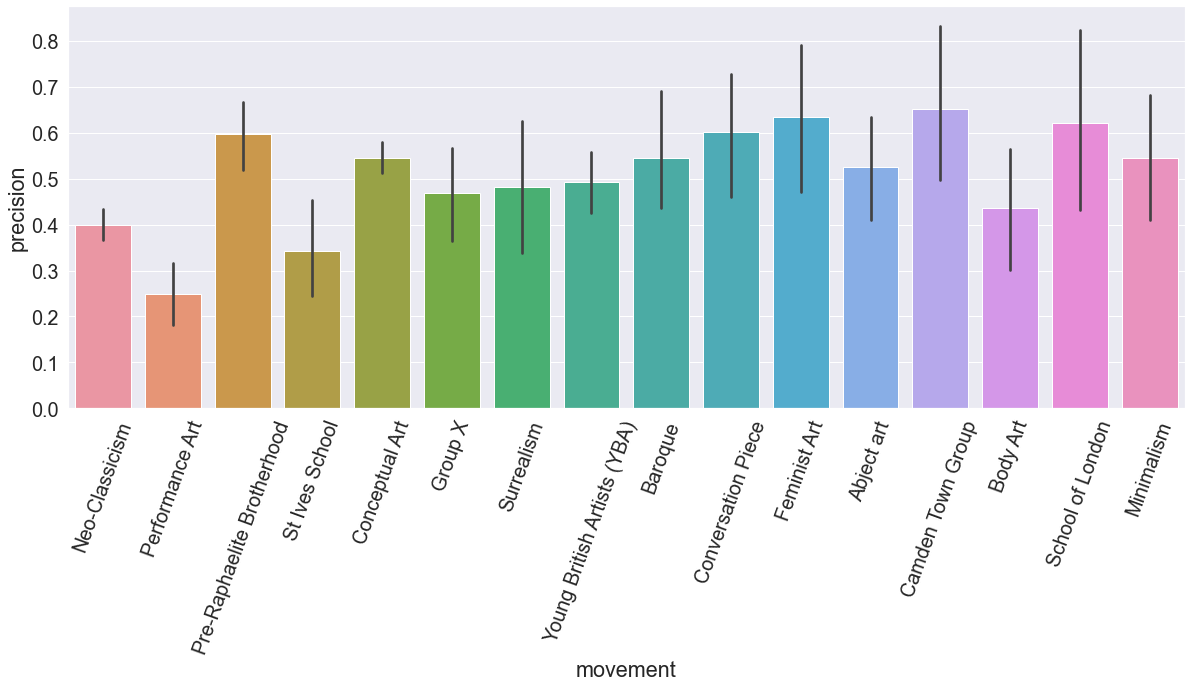

In [92]:
import seaborn as sns
sns.set(style="whitegrid")
merged = groups.filter(lambda x: len(x) > 5)
tips = merged.groupby('movement')['precision'].mean()
plt.figure(figsize=(17,10))
sns.set(font_scale=1.8, )
ax = sns.barplot(x=merged.movement, y=merged.precision,)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, )
plt.tight_layout()
plt.savefig('./results/precision_per_movement.png')
plt.show()
#x="movement", y="precision", data=tips)

In [93]:
dic = merged.groupby('movement')['precision'].mean()

In [94]:
#dic['Futurism']

In [95]:
merged[merged.movement == 'Futurism']

Empty DataFrame
Columns: [precision, movement]
Index: []

In [96]:
data_info = pd.read_csv('../../Capstone/artwork_data.csv', verbose=0)
year = data_info[['accession_number', 'year']]
year = year.dropna()
year = year[year.year != 'no date']
year = year[year.year != 'c.1997-9']

C:\Users\Ludovica\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [97]:
year['decemnium'] = year['year'].map(lambda x: str(int(x))[:-1])
merged1 = pd.merge(merged, year, left_index=True, right_on='accession_number')
merged1

precision                    movement accession_number  year decemnium
66551   0.333333              Neo-Classicism           T11186  1805       180
68811   0.333333             Performance Art           T13480  1995       199
64401   0.714286  Pre-Raphaelite Brotherhood           T09036  1861       186
66538   0.600000              Neo-Classicism           T11173  1807       180
66544   0.250000              Neo-Classicism           T11179  1807       180
...          ...                         ...              ...   ...       ...
67855   0.571429              Conceptual Art           T12515  1970       197
68391   0.833333              Conceptual Art           T13059  1976       197
68384   0.428571              Conceptual Art           T13052  1976       197
63502   0.333333          Conversation Piece           T08137  1759       175
69048   0.500000                  Minimalism           T13717  1991       199

[543 rows x 5 columns]

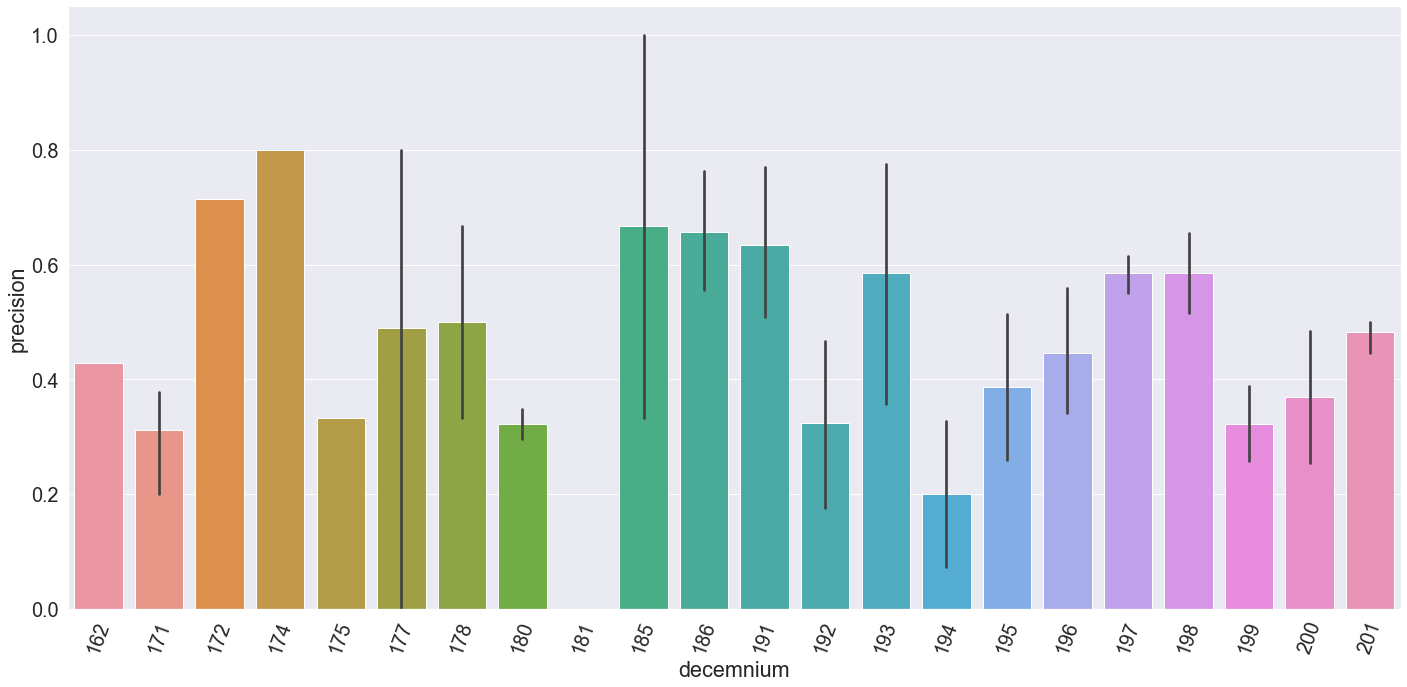

decemnium
162    1.0
171    1.0
172    1.0
174    1.0
175    1.0
177    1.0
178    1.0
180    1.0
181    1.0
185    1.0
186    1.0
191    1.0
192    1.0
193    1.0
194    1.0
195    1.0
196    1.0
197    1.0
198    1.0
199    1.0
200    1.0
201    1.0
dtype: float64%


In [98]:
tips = merged1.groupby('decemnium').count()
plt.figure(figsize=(20,10))
sns.set(font_scale=1.8, )
ax = sns.barplot(x=merged1.decemnium, y=merged1.precision,)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, )
percent = "{}%".format(merged1.groupby('decemnium')['movement'].count()/merged1.groupby('decemnium')['precision'].count())
plt.tight_layout()
plt.show()
print(percent)

In [30]:
year['decemnium'] = year['year'].map(lambda x: str(int(x))[:-1])
merged2 = pd.merge(pred, year, left_index=True, right_on='accession_number')
merged2

precision accession_number  year decemnium
67919   0.666667           T12579  2000       200
66387   0.500000           T11022  1819       181
63821   0.333333           T08456  1789       178
67902   0.200000           T12562  1997       199
66551   0.333333           T11186  1805       180
...          ...              ...   ...       ...
69048   0.500000           T13717  1991       199
65348   0.500000           T09983  1814       181
64248   1.000000           T08883  1787       178
64809   1.000000           T09444  1872       187
68329   0.500000           T12997  1796       179

[2092 rows x 4 columns]

In [42]:
tips = merged2.groupby('decemnium').count()
plt.figure(figsize=(15,7))
sns.set(font_scale=1., )
groups = merged2.groupby('decemnium')
merged2 = groups.filter(lambda x: len(x) > 5)
ax = sns.barplot(x=merged2.decemnium, y=merged2.precision, data=merged2)#.groupby('decemnium').sum())
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, )
percent = "{}%".format(merged1.groupby('decemnium')['movement'].count()/merged2.groupby('decemnium')['precision'].count())
for index, row in merged2.groupby('decemnium').sum().iterrows():
    ax.text(int(row.name), row.precision, percent, color='black', ha="center")
plt.tight_layout()
plt.savefig('./results/precision_per_year.png')
plt.show()
print(percent)

C:\Users\Ludovica\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  # This is added back by InteractiveShellApp.init_path()


decemnium
171         NaN
173         NaN
174         NaN
175         NaN
176         NaN
177    0.035714
178    0.011364
179         NaN
180    0.553435
181    0.010417
182         NaN
183         NaN
184         NaN
185    0.133333
186    0.740741
187         NaN
191         NaN
192    0.054054
193    0.069767
194    0.116279
195    0.277108
196    0.157534
197    0.478927
198    0.283186
199    0.346821
200    0.065455
201    0.190476
dtype: float64%
